##Creating Custom Filter Banks with OpenCV

Suppose in order to extract curved lines from the image, we create a bank of filters (matched filters) designed to illicit a response from line segments of different orientation. To reconstruct the curves we apply each filter in the bank to the given image and then return the maximum response:

$$I_{res} = \max\limits_{x,y} (I * F_i)$$

where "*" is a convolution operation, $I$ - original image, $F_i$ - filters in the filter bank.

[This article](http://www4.comp.polyu.edu.hk/~cslzhang/paper/CBM-MF.pdf) uses matched filters based on Gaussian and derivative of Gaussian for blood vessel detection - an important part of retinal image segmentation.

They use a Gaussian of the form:

$$f(x, y)= \frac{1}{\sqrt{2\pi}s}\exp(-\frac{x^2}{2s^2}) - m,\ for\ |x| \leq t\cdot s,\ |y| \leq L/2 \ \ \ (1)$$ 
Where $m$ - is the averaged value of the filter:
$$m = \frac{\int\limits_{-ts}^{ts} \frac{1}{\sqrt{2\pi}s}\exp(-\frac{x^2}{2s^2})dx }{2ts} $$

They also use the first order derivative of this filter (FDOG):

$$g(x, y) = - \frac{x}{\sqrt{2\pi}s^3}\exp(-\frac{x^2}{2s^2}),\ for\ |x| \leq t\cdot s,\ |y| \leq L/2 \ \ \ (2)$$

In [1]:
# Auxillary stuff

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import cv2
import pandas as pd
from math import exp, pi, sqrt
from numbapro import vectorize

def show_images(images,titles=None, scale=1.3):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.imshow(image, cmap = cm.Greys_r)
        else:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        a.set_title(title)
        plt.axis("off")
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches(), dtype=np.float) * n_ims / scale)
    plt.show()

To create these kernels we first fill the $2ts \times L$ square with values of their $x$ coordinate. Then we create a ufunc using numbapro $\color{green}{@vectorize}$ decorator so that (1) or (2) above could be applied in one shot. Closures appear to be supported by this decorator, so these functions can be generated dynamically, based on the $s$ parameter. Also, since OpenCV $\color{green}{filter2D}$ API uses correlation rather than convolution to apply filters, we need to use $\color{green}{flip}$ before the kernel is returned.

In [2]:
def _filter_kernel_mf_fdog(L, sigma, t = 3, mf = True):
    dim_y = int(L)
    dim_x = 2 * int(t * sigma)
    arr = np.zeros((dim_y, dim_x), 'f')
    
    ctr_x = dim_x / 2 
    ctr_y = int(dim_y / 2.)

    # an un-natural way to set elements of the array
    # to their x coordinate. 
    # x's are actually columns, so the first dimension of the iterator is used
    it = np.nditer(arr, flags=['multi_index'])
    while not it.finished:
        arr[it.multi_index] = it.multi_index[1] - ctr_x
        it.iternext()

    two_sigma_sq = 2 * sigma * sigma
    sqrt_w_pi_sigma = 1. / (sqrt(2 * pi) * sigma)
    if not mf:
        sqrt_w_pi_sigma = sqrt_w_pi_sigma / sigma ** 2

    @vectorize(['float32(float32)'], target='cpu')
    def k_fun(x):
        return sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    @vectorize(['float32(float32)'], target='cpu')
    def k_fun_derivative(x):
        return -x * sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    if mf:
        kernel = k_fun(arr)
        kernel = kernel - kernel.mean()
    else:
       kernel = k_fun_derivative(arr)

    # return the "convolution" kernel for filter2D
    return cv2.flip(kernel, -1) 


And to call this helper:

In [3]:
def fdog_filter_kernel(L, sigma, t = 3):
    '''
    K = - (x/(sqrt(2 * pi) * sigma ^3)) * exp(-x^2/2sigma^2), |y| <= L/2, |x| < s * t
    '''
    return _filter_kernel_mf_fdog(L, sigma, t, False)

def gaussian_matched_filter_kernel(L, sigma, t = 3):
    '''
    K =  1/(sqrt(2 * pi) * sigma ) * exp(-x^2/2sigma^2), |y| <= L/2, |x| < s * t
    '''
    return _filter_kernel_mf_fdog(L, sigma, t, True)

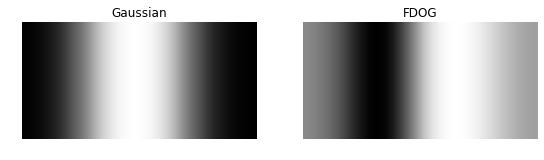

In [4]:
gf = gaussian_matched_filter_kernel(15, 5)
fdog = fdog_filter_kernel(15, 5)

# visualize:
show_images([gf, fdog], ["Gaussian", "FDOG"])

Now we create a bank of these filters, each one rotated by $15^{\circ}$ from the previous one:
$F_i=Rotate(F_{i-1}, 15^{\circ})$ Thus we create a bank of 12 such filters. 

Rotation can be expressed as an affine transformation. Thus, in order to accomplish this with OpenCV, we first create a rotation matrix and then apply it using corresponding OpenCV APIs.

In [5]:
def createMatchedFilterBank(K, n = 12):
    '''
    Given a kernel, create matched filter bank
    '''
    rotate = 180 / n
    center = (K.shape[1] / 2, K.shape[0] / 2)
    cur_rot = 0
    kernels = [K]

    for i in range(1, n):
        cur_rot += rotate
        r_mat = cv2.getRotationMatrix2D(center, cur_rot, 1)
        k = cv2.warpAffine(K, r_mat, (K.shape[1], K.shape[0]))
        kernels.append(k)

    return kernels

And to see the results:

Gaussian


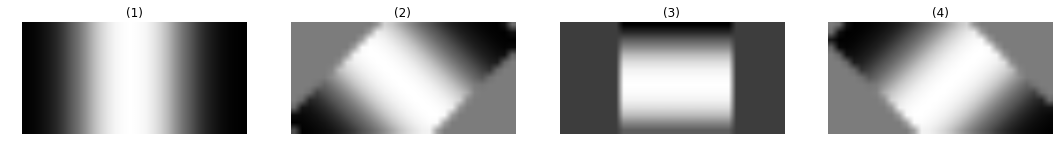

FDOG


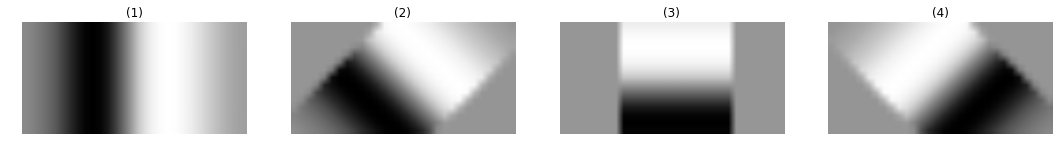

In [6]:
bank_gf = createMatchedFilterBank(gf, 4)
bank_fdog = createMatchedFilterBank(fdog, 4)

print "Gaussian"
show_images(bank_gf)
print "FDOG"
show_images(bank_fdog)

In [7]:
# here are the values for one of these rotated images:
bank_gf[1]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.00706917,  0.02442968,  0.01962757,  0.01276451,
         0.00619412, -0.00023838, -0.0062054 , -0.01145587, -0.01605165,
        -0.01994629, -0.02313657, -0.0257983 , -0.02769874, -0.02931222,
        -0.03055923, -0.03133851, -0.03196213, -0.02729871, -0.00505532],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.00912069,  0.03521829,  0.03231619,  0.02605832,  0.01962757,
         0.01276451,  0.00619412, -0.00023838, -0.0062054 , -0.01145587,
        -0.01605165, -0.01994629, -0.02313657, -0.0257983 , -0.02769874,
        -0.02931222, -0.03055923, -0.03133851, -0.03196212, -0.02729871],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0

In [8]:
#Applying the filter bank
def applyFilters(im, kernels):
    '''
    Given a filter bank, apply them and record maximum response
    '''
    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)